In [3]:
import torch
import numpy as np
#import numpy.typing as npt
import sympy as sp
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib import animation, rc

In [92]:
t = sp.symbols('t')
x = sp.Function('x')(t)
xd = sp.diff(x, t)
xdd = sp.diff(x,(t,2))

c = np.array([0.1,1,0.1, 0.39, 1.4])
#duff_eq = sp.Eq(xdd + c[0]*xd + c[1]*x + c[2]*x**3, c[3]*sp.cos(t*c[4]))
duff_eq = sp.Eq(xdd + c[0]*xd + c[1]*x, 0)
xd_eq = sp.solve(duff_eq, xd)[0]
xdd_eq = sp.solve(duff_eq, xdd)[0]


def deriv(X, T):
    xv, xdv = X
    xddv = xdd_eq.evalf(subs={x:xv, xd:xdv, t:T})
    return xdv, xddv


def solve_duffing(tmax, dt, x0, v0):
    t = np.arange(0, tmax, dt)
    # Initial conditions: x, xdot
    X0 = [x0, v0]
    X = odeint(deriv, X0, t)
    return t, X


x0, v0 = 0, -1
tmax = 50
dt = 0.1

v0_arr = []
t, X = solve_duffing(tmax, dt, x0, v0)
q, p = X.T

In [93]:
X_data = X[0:len(X)-1]
Y_data = X[1:len(X)]
Y_data = Y_data - X_data

In [104]:
def L2_loss(u, v):
    return (u-v).pow(2).mean()

def getJ(n_dim: int) -> np.ndarray:
    I = np.identity(n_dim)
    zero = np.zeros((n_dim,n_dim))
    J = np.block([[zero, I], [-I, zero]])
    return J

class HNN(torch.nn.Module):
    def __init__(self, n_dim, device):
        super(HNN, self).__init__()
        self.J = torch.tensor(getJ(n_dim), device=device,dtype=torch.float32)
        self.flatten = torch.nn.Flatten()
        self.linear_sigm_stack = torch.nn.Sequential(
            torch.nn.Linear(n_dim*2, 4),
            torch.nn.Tanh(),
            torch.nn.Linear(4, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 4),
            torch.nn.Tanh(),
            torch.nn.Linear(4, n_dim*2)
        )

    def forward(self, x):
        #x = self.flatten(x)
        nn_output = self.linear_sigm_stack(x)
        return nn_output
    
    def ham_eqiations(self, x):
        nn_output = self.forward(x)
        grad = torch.autograd.grad(nn_output.sum(), x, create_graph=True)[0]
        z = self.J @ grad
        return z
    
device = "cuda" if torch.cuda.is_available() else "cpu"
model = HNN(1, device).to(device)

X_final = [torch.tensor(X_data[i], requires_grad=True, dtype=torch.float32)for i in range(len(X_data))]
for a in X_final:
    a.retain_grad()
    
Y_final = [torch.tensor(Y_data[i], requires_grad=True, dtype=torch.float32)for i in range(len(Y_data))]

data = [(X_final[i], Y_final[i]) for i in range(len(X_final))]
loader = torch.utils.data.DataLoader(data, batch_size = 16, shuffle = False)


In [105]:
model.train()

criterion = torch.nn.L1Loss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses =[]
for i in range(20):
    for local_batch, local_labels in loader:
        loss=0
        for j in range(len(local_batch)):
            x, y = local_batch[j].to(device), local_labels[j].to(device)
            #x.retain_grad()
            #print(local_batch[j])
            #Forward pass: Compute predicted y by passing x to the model
            y_pred = model.ham_eqiations(x)
            #Compute and print loss
            loss += L2_loss(y_pred, y)
           
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())
    print(loss.item())

1.889405211841222e-05
7.594517228426412e-05
5.033757406636141e-05
5.1577801059465855e-05
5.355210305424407e-05
5.2152867283439264e-05
5.550343848881312e-05
6.542378105223179e-05
8.02021095296368e-05
3.7749141483800486e-05
2.602599488454871e-05
3.174442827003077e-05
2.332637450308539e-05
5.661588602379197e-07
1.5163946954999119e-05
8.10358687886037e-06
1.0791422937472817e-05
9.468017196923029e-06
9.028493877849542e-06
7.847365850466304e-06


In [106]:
model.eval()

HNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigm_stack): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=4, bias=True)
    (9): Tanh()
    (10): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [114]:
Y_pred = [model.ham_eqiations(data[i][0].to(device)).cpu().detach().numpy() for i in range(len(data))]
Y_pred = np.array(Y_pred).T
Q_pred = [np.trapz(Y_pred[0][0:i]) + x0 for i in range(len(data))]
P_pred = [np.trapz(Y_pred[1][0:i]) + v0 for i in range(len(data))]

AttributeError: 'tuple' object has no attribute 'to'

In [115]:
def model_deriv(x, t):
    x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True, device=device)
    return model.ham_eqiations(x_torch).to('cpu').detach().numpy()/dt
model.to(device)
X = odeint(model_deriv, [0, -0.95], t)

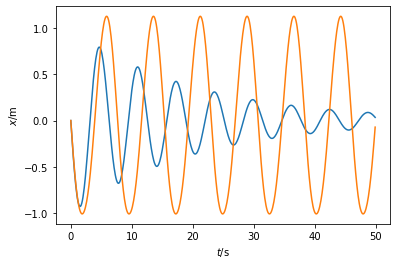

In [118]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$t / \mathrm{s}$')
ax.set_ylabel(r'$x / \mathrm{m}$')
ln2, = ax.plot(t, q)
ln3, = ax.plot(t, X.T[0])
#ax.set_ylim(np.min(x), np.max(x))

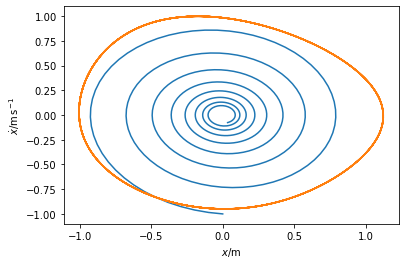

In [119]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$x / \mathrm{m}$')
ax.set_ylabel(r'$\dot{x} / \mathrm{m\,s^{-1}}$')
ln3, = ax.plot(q, p)
ln3, = ax.plot(X.T[0], X.T[1])
#ax.set_xlim(np.min(q), np.max(q))
#ax.set_ylim(np.min(p), np.max(p))